In [1]:
# ==============================================================================
# CELL 1: SETUP AND VERIFICATION
# ==============================================================================

# Step 1.1: Import Libraries
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
# Import the new, more powerful models
from tensorflow.keras.applications import EfficientNetV2B2, ResNet101V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Step 1.2: Force Remount Google Drive for a fresh connection
print("Attempting to force remount Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("✅ Drive remounted successfully.")

# Step 1.3: Define and Verify CORRECT File Paths
BASE_PATH = '/content/drive/MyDrive/Deepfake/'
FAKE_IMG_PATH = os.path.join(BASE_PATH, 'fake_cifake_images/')
REAL_IMG_PATH = os.path.join(BASE_PATH, 'real_cifake_images/')
TEST_IMG_PATH = os.path.join(BASE_PATH, 'test/')

FAKE_JSON_PATH = os.path.join(BASE_PATH, 'fake_cifake_preds.json')
REAL_JSON_PATH = os.path.join(BASE_PATH, 'real_cifake_preds.json')

# This safety check lists your actual files.
print(f"\nVerifying contents of the directory: {BASE_PATH}")
!ls -l /content/drive/MyDrive/Deepfake/

Attempting to force remount Google Drive...
Mounted at /content/drive
✅ Drive remounted successfully.

Verifying contents of the directory: /content/drive/MyDrive/Deepfake/
total 137
drwx------ 2 root root  4096 Oct 19 19:59 fake_cifake_images
-rw------- 1 root root 63895 Oct 19 19:55 fake_cifake_preds.json
drwx------ 2 root root  4096 Oct 19 19:56 real_cifake_images
-rw------- 1 root root 63895 Oct 19 19:55 real_cifake_preds.json
drwx------ 2 root root  4096 Oct 19 20:01 test


In [2]:
# ==============================================================================
# CELL 2: LOAD, PROCESS, AND ANALYZE DATA
# ==============================================================================
print("Loading and processing datasets for classification...")
try:
    df_fake = pd.DataFrame(json.load(open(FAKE_JSON_PATH)))
    df_real = pd.DataFrame(json.load(open(REAL_JSON_PATH)))

    df_fake = df_fake.rename(columns={'index': 'image_id'})
    df_real = df_real.rename(columns={'index': 'image_id'})

    df_fake['label'] = 0
    df_real['label'] = df_real['prediction'].apply(lambda x: 1 if x == 'real' else 0)

    df_fake['image_path'] = FAKE_IMG_PATH + df_fake['image_id'].astype(str) + '.png'
    df_real['image_path'] = REAL_IMG_PATH + df_real['image_id'].astype(str) + '.png'

    df_train = pd.concat([df_fake, df_real], ignore_index=True)

    TARGET_COLUMN = 'label'
    IMG_SIZE = 224 # ResNet and EfficientNet work well with this size
    BATCH_SIZE = 32

    print("✅✅✅ Successfully loaded and processed datasets!")
    print(f"\nConfiguration set: Target='{TARGET_COLUMN}', Image Size={IMG_SIZE}, Batch Size={BATCH_SIZE}")

except Exception as e:
    print(f"❌ An error occurred: {e}")
    raise

Loading and processing datasets for classification...
✅✅✅ Successfully loaded and processed datasets!

Configuration set: Target='label', Image Size=224, Batch Size=32


In [3]:
# ==============================================================================
# CELL 3: DATA PIPELINE CREATION
# ==============================================================================
print("Building the Data Pipeline with model-specific preprocessing...")

# We will use this function to create pipelines for each model
def create_pipeline(df, preprocessor, is_training=True):
    filepaths = df['image_path'].values
    labels = df[TARGET_COLUMN].values if TARGET_COLUMN in df.columns else np.zeros(len(df))

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    def parse_function(filename, label):
        image_string = tf.io.read_file(filename)
        image = tf.image.decode_png(image_string, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        # Apply the model-specific preprocessing
        image = preprocessor(image)
        return image, label

    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(buffer_size=1024)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Split data before creating pipelines
train_df, val_df = train_test_split(df_train, test_size=0.15, random_state=42, stratify=df_train[TARGET_COLUMN])

print(f"✅ Data split. Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Building the Data Pipeline with model-specific preprocessing...
✅ Data split. Training samples: 1700, Validation samples: 300


In [4]:
# ==============================================================================
# CELL 4: DEFINE MODEL ARCHITECTURES
# ==============================================================================
print("Defining model builder functions...")

# Define a shared head for both models for consistency
def build_head(base_model_output):
    x = GlobalAveragePooling2D()(base_model_output)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Dense(1, activation='sigmoid')(x)

def build_effnet_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetV2B2(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = False
    outputs = build_head(base_model.output)
    model = Model(inputs, outputs)
    return model

def build_resnet_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = ResNet101V2(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = False
    outputs = build_head(base_model.output)
    model = Model(inputs, outputs)
    return model

print("✅ Model builders are ready.")

Defining model builder functions...
✅ Model builders are ready.


In [ ]:
# ==============================================================================
# CELL 5: TRAIN MODEL 1 - EFFICIENTNETV2B2
# ==============================================================================
print("--- Starting Experiment 1: Training EfficientNetV2B2 ---")

# 1. Create the specific data pipeline for this model
effnet_preprocessor = tf.keras.applications.efficientnet_v2.preprocess_input
train_ds_effnet = create_pipeline(train_df, effnet_preprocessor)
val_ds_effnet = create_pipeline(val_df, effnet_preprocessor, is_training=False)

# 2. Build the model
effnet_model = build_effnet_model()

# 3. Compile for Phase 1
effnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy', metrics=['accuracy'])

# 4. Define callbacks
callbacks_effnet = [
    ModelCheckpoint('best_effnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# 5. Train Phase 1
print("\n--- Training Phase 1 (Head) ---")
history_effnet_1 = effnet_model.fit(train_ds_effnet, epochs=30, validation_data=val_ds_effnet, callbacks=callbacks_effnet)

# 6. Train Phase 2 (Fine-Tuning)
print("\n--- Training Phase 2 (Fine-Tuning) ---")
effnet_model.trainable = True
effnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                     loss='binary_crossentropy', metrics=['accuracy'])
history_effnet_2 = effnet_model.fit(train_ds_effnet, epochs=30, validation_data=val_ds_effnet,
                                    callbacks=callbacks_effnet, initial_epoch=history_effnet_1.epoch[-1] + 1)

print("✅ EfficientNetV2B2 training complete.")

--- Starting Experiment: Training EfficientNetV2B2 with Gradual Unfreezing ---

--- Training Phase 1 (Head) ---
Epoch 1/30


In [6]:
# ==============================================================================
# CELL 6: TRAIN MODEL 2 - RESNET101V2
# ==============================================================================
print("\n\n--- Starting Experiment 2: Training ResNet101V2 ---")

# 1. Create the specific data pipeline for this model
resnet_preprocessor = tf.keras.applications.resnet_v2.preprocess_input
train_ds_resnet = create_pipeline(train_df, resnet_preprocessor)
val_ds_resnet = create_pipeline(val_df, resnet_preprocessor, is_training=False)

# 2. Build the model
resnet_model = build_resnet_model()

# 3. Compile for Phase 1
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy', metrics=['accuracy'])

# 4. Define callbacks
callbacks_resnet = [
    ModelCheckpoint('best_resnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# 5. Train Phase 1
print("\n--- Training Phase 1 (Head) ---")
history_resnet_1 = resnet_model.fit(train_ds_resnet, epochs=30, validation_data=val_ds_resnet, callbacks=callbacks_resnet)

# 6. Train Phase 2 (Fine-Tuning)
print("\n--- Training Phase 2 (Fine-Tuning) ---")
resnet_model.trainable = True
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                     loss='binary_crossentropy', metrics=['accuracy'])
history_resnet_2 = resnet_model.fit(train_ds_resnet, epochs=30, validation_data=val_ds_resnet,
                                    callbacks=callbacks_resnet, initial_epoch=history_resnet_1.epoch[-1] + 1)

print("✅ ResNet101V2 training complete.")



--- Starting Experiment 2: Training ResNet101V2 ---
171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Training Phase 1 (Head) ---
Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 364s 4s/step - accuracy: 0.6222 - loss: 0.6930 - val_accuracy: 0.7933 - val_loss: 0.4640 - learning_rate: 0.0010
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.7751 - loss: 0.4638 - val_accuracy: 0.7667 - val_loss: 0.4307 - learning_rate: 0.0010
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.8142 - loss: 0.3871 - val_accuracy: 0.8167 - val_loss: 0.4393 - learning_rate: 0.0010
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.8603 - loss: 0.3173 - val_accuracy: 0.8333 - val_loss: 0.3900 - learning_rate: 0.0010
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.8634 - loss: 0.3073 - val_accuracy: 0.8300 - val_loss: 0.3960 - learning_rate: 0.0010
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.9013 - loss: 0.2452 - val_accu

Starting final evaluation of the ENSEMBLE model on the validation set...
Loading best trained models...
Generating validation predictions from Model 1 (EfficientNet)...
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 889ms/step
Generating validation predictions from Model 2 (ResNet)...
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 765ms/step

✅ Final ENSEMBLE Validation Accuracy: 0.9000 (90.00%)

📊 Ensemble Classification Report:

              precision    recall  f1-score   support

    fake (0)       0.91      0.90      0.90       154
    real (1)       0.89      0.90      0.90       146

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300


matrix Ensemble Confusion Matrix:



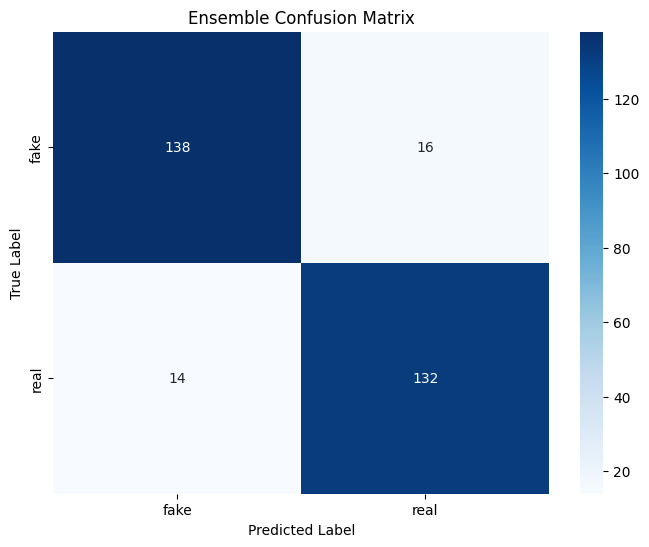

In [11]:
# ==============================================================================
# FINAL ENSEMBLE EVALUATION ON VALIDATION SET
# ==============================================================================
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Starting final evaluation of the ENSEMBLE model on the validation set...")

try:
    # 1. Load the best saved models
    print("Loading best trained models...")
    effnet_model = tf.keras.models.load_model('best_effnet_model.keras')
    resnet_model = tf.keras.models.load_model('best_resnet_model.keras')

    # 2. Get the true labels from our validation dataframe
    true_labels = val_df[TARGET_COLUMN].values

    # 3. Generate predictions from both models on the validation set
    print("Generating validation predictions from Model 1 (EfficientNet)...")
    preds_effnet_val = effnet_model.predict(val_ds_effnet)
    print("Generating validation predictions from Model 2 (ResNet)...")
    preds_resnet_val = resnet_model.predict(val_ds_resnet)

    # 4. Average the predictions to get the final ensemble probability
    final_preds_val = (preds_effnet_val + preds_resnet_val) / 2.0
    predicted_labels_val = (final_preds_val > 0.5).astype(int).flatten()

    # 5. Calculate and Print Final Ensemble Accuracy
    accuracy = accuracy_score(true_labels, predicted_labels_val)
    print("\n==================================================")
    print(f"✅ Final ENSEMBLE Validation Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    print("==================================================")

    # 6. Print a Detailed Classification Report
    print("\n📊 Ensemble Classification Report:\n")
    print(classification_report(true_labels, predicted_labels_val, target_names=['fake (0)', 'real (1)']))

    # 7. Display a Confusion Matrix
    print("\nmatrix Ensemble Confusion Matrix:\n")
    cm = confusion_matrix(true_labels, predicted_labels_val)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Ensemble Confusion Matrix')
    plt.show()

except Exception as e:
    print(f"❌ An error occurred during evaluation: {e}")
    raise

In [14]:
# ==============================================================================
# EXPERIMENT: OPTIMIZE ENSEMBLE WEIGHTS
# ==============================================================================
from sklearn.metrics import accuracy_score

print("Running Experiment: Optimizing Ensemble Weights...")

# These variables are already in memory from the previous evaluation cell:
# - preds_effnet_val (predictions from EfficientNet)
# - preds_resnet_val (predictions from ResNet)
# - true_labels (the correct 0/1 answers)

best_accuracy = 0.0
best_weight_effnet = 0.0

# We will test weights from 0.0 to 1.0 in small steps
for weight in np.arange(0, 1.01, 0.01):
    # Calculate the new weighted average
    weighted_preds = (preds_effnet_val * weight) + (preds_resnet_val * (1.0 - weight))

    # Convert probabilities to final 0/1 predictions
    weighted_labels = (weighted_preds > 0.5).astype(int).flatten()

    # Calculate accuracy for this specific weight
    accuracy = accuracy_score(true_labels, weighted_labels)

    # If this weight is the best so far, save it
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weight_effnet = weight

print("\n--- Ensemble Optimization Results ---")
print(f"Optimal Weight for EfficientNet: {best_weight_effnet:.2f}")
print(f"Optimal Weight for ResNet: {1.0 - best_weight_effnet:.2f}")
print(f"🔥 New Maximum Validation Accuracy: {best_accuracy:.4f} ({best_accuracy:.2%})")

Running Experiment: Optimizing Ensemble Weights...

--- Ensemble Optimization Results ---
Optimal Weight for EfficientNet: 0.43
Optimal Weight for ResNet: 0.57
🔥 New Maximum Validation Accuracy: 0.9033 (90.33%)


In [16]:
# ==============================================================================
# FINAL SUBMISSION (Using the 90.33% Champion Model)
# ==============================================================================
print("Generating final ensemble predictions with your BEST OPTIMIZED WEIGHTS...")

# --- These are the optimal weights you found that gave 90.33% accuracy ---
OPTIMAL_WEIGHT_EFFNET = 0.43
OPTIMAL_WEIGHT_RESNET = 0.57
# ------------------------------------------------------------------

try:
    # 1. Load your best v1 saved models
    print("Loading best trained models (v1)...")
    effnet_model = tf.keras.models.load_model('best_effnet_model.keras')
    resnet_model = tf.keras.models.load_model('best_resnet_model.keras')

    # 2. Prepare test data
    test_image_files = os.listdir(TEST_IMG_PATH)
    df_test = pd.DataFrame({
        'image_id': test_image_files,
        'image_path': TEST_IMG_PATH + pd.Series(test_image_files),
        TARGET_COLUMN: 0
    })
    test_ds_effnet = create_pipeline(df_test, effnet_preprocessor, is_training=False)
    test_ds_resnet = create_pipeline(df_test, resnet_preprocessor, is_training=False)

    # 3. Generate predictions
    print("Generating predictions from Model 1 (EfficientNet)...")
    preds_effnet = effnet_model.predict(test_ds_effnet)
    print("Generating predictions from Model 2 (ResNet)...")
    preds_resnet = resnet_model.predict(test_ds_resnet)

    # 4. Apply your proven 43/57 weighted average
    print(f"Applying optimal weights: {OPTIMAL_WEIGHT_EFFNET*100:.0f}% EffNet, {OPTIMAL_WEIGHT_RESNET*100:.0f}% ResNet")
    final_preds = (preds_effnet * OPTIMAL_WEIGHT_EFFNET) + (preds_resnet * OPTIMAL_WEIGHT_RESNET)

    # 5. Create the submission file
    predicted_labels = (final_preds > 0.5).astype(int).flatten()
    df_test['prediction'] = np.where(predicted_labels == 1, 'real', 'fake')
    df_test['index'] = df_test['image_id'].str.replace('.png', '', regex=False).astype(int)

    submission_list = df_test[['index', 'prediction']].to_dict(orient='records')
    submission_list.sort(key=lambda x: x['index'])

    with open('submission_optimized.json', 'w') as f:
        json.dump(submission_list, f, indent=4)

    print("\n==================================================")
    print("🎉 MISSION COMPLETE! 🎉")
    print("✅ Optimized ensemble submission.json created successfully!")
    print("This file is ready to be submitted to the hackathon. Good luck!")
    print("==================================================")

except Exception as e:
    print(f"❌ An error occurred during prediction: {e}")
    raise

Generating final ensemble predictions with your BEST OPTIMIZED WEIGHTS...
Loading best trained models (v1)...
Generating predictions from Model 1 (EfficientNet)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step
Generating predictions from Model 2 (ResNet)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 634ms/step
Applying optimal weights: 43% EffNet, 57% ResNet

🎉 MISSION COMPLETE! 🎉
✅ Optimized ensemble submission.json created successfully!
This file is ready to be submitted to the hackathon. Good luck!
